# Exploratory Data Analysis - Loan Payback Prediction

This notebook explores the dataset for the Kaggle Playground Series competition on predicting loan payback.

**Competition Details:**
- **Task:** Binary Classification (predict if loan will be paid back)
- **Metric:** ROC-AUC
- **Target Variable:** `loan_paid_back` (1 = paid back, 0 = not paid back)


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


## 1. Load Data


In [2]:
# Load datasets
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

print("=" * 60)
print("DATASET SHAPES")
print("=" * 60)
print(f"Training set: {train_df.shape[0]:,} rows × {train_df.shape[1]} columns")
print(f"Test set: {test_df.shape[0]:,} rows × {test_df.shape[1]} columns")
print(f"Sample submission: {sample_submission.shape[0]:,} rows × {sample_submission.shape[1]} columns")
print()
print("=" * 60)
print("TRAINING SET - FIRST FEW ROWS")
print("=" * 60)
display(train_df.head())


DATASET SHAPES
Training set: 593,994 rows × 13 columns
Test set: 254,569 rows × 12 columns
Sample submission: 254,569 rows × 2 columns

TRAINING SET - FIRST FEW ROWS


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


## 2. Basic Data Information


In [3]:
print("=" * 60)
print("DATASET INFO")
print("=" * 60)
train_df.info()


DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [4]:
print("=" * 60)
print("FEATURE TYPES")
print("=" * 60)

# Separate numerical and categorical features
numerical_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()

# Remove target and id from numerical features
numerical_features = [f for f in numerical_features if f not in ['id', 'loan_paid_back']]

print(f"\nNumerical Features ({len(numerical_features)}):")
for feat in numerical_features:
    print(f"  - {feat}")

print(f"\nCategorical Features ({len(categorical_features)}):")
for feat in categorical_features:
    print(f"  - {feat}")

print(f"\nTarget Variable: loan_paid_back")


FEATURE TYPES

Numerical Features (5):
  - annual_income
  - debt_to_income_ratio
  - credit_score
  - loan_amount
  - interest_rate

Categorical Features (6):
  - gender
  - marital_status
  - education_level
  - employment_status
  - loan_purpose
  - grade_subgrade

Target Variable: loan_paid_back


## 3. Missing Values Analysis


In [5]:
# Check for missing values
missing_train = train_df.isnull().sum()
missing_test = test_df.isnull().sum()

missing_df = pd.DataFrame({
    'Train_Missing': missing_train,
    'Train_Percent': (missing_train / len(train_df) * 100).round(2),
    'Test_Missing': missing_test,
    'Test_Percent': (missing_test / len(test_df) * 100).round(2)
})

missing_df = missing_df[(missing_df['Train_Missing'] > 0) | (missing_df['Test_Missing'] > 0)]

if len(missing_df) > 0:
    print("=" * 60)
    print("MISSING VALUES")
    print("=" * 60)
    display(missing_df)
else:
    print("=" * 60)
    print("MISSING VALUES: NONE FOUND ✓")
    print("=" * 60)


MISSING VALUES: NONE FOUND ✓


## 4. Target Variable Analysis


TARGET VARIABLE DISTRIBUTION

Counts:
  0 (Not Paid Back): 119,500 (20.12%)
  1 (Paid Back):     474,494 (79.88%)

Total: 593,994


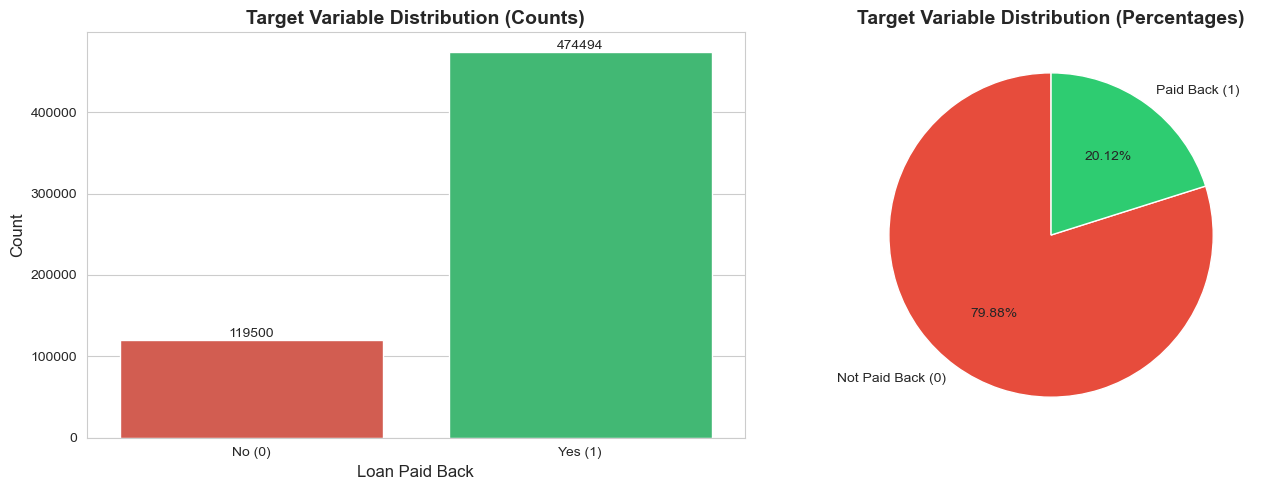


Imbalanced dataset detected.


In [6]:
# Target distribution
target_counts = train_df['loan_paid_back'].value_counts()
target_percentages = train_df['loan_paid_back'].value_counts(normalize=True) * 100

print("=" * 60)
print("TARGET VARIABLE DISTRIBUTION")
print("=" * 60)
print(f"\nCounts:")
print(f"  0 (Not Paid Back): {target_counts[0]:,} ({target_percentages[0]:.2f}%)")
print(f"  1 (Paid Back):     {target_counts[1]:,} ({target_percentages[1]:.2f}%)")
print(f"\nTotal: {len(train_df):,}")

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=train_df, x='loan_paid_back', ax=axes[0], palette=['#e74c3c', '#2ecc71'])
axes[0].set_title('Target Variable Distribution (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Loan Paid Back', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['No (0)', 'Yes (1)'])

# Add count labels on bars
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', fontsize=10)

# Pie chart
axes[1].pie(target_counts.values, labels=['Not Paid Back (0)', 'Paid Back (1)'], 
            autopct='%1.2f%%', startangle=90, colors=['#e74c3c', '#2ecc71'])
axes[1].set_title('Target Variable Distribution (Percentages)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n{'Balanced' if 40 < target_percentages[0] < 60 else 'Imbalanced'} dataset detected.")


## 5. Numerical Features Analysis


In [7]:
print("=" * 60)
print("NUMERICAL FEATURES - DESCRIPTIVE STATISTICS")
print("=" * 60)
display(train_df[numerical_features + ['loan_paid_back']].describe())


NUMERICAL FEATURES - DESCRIPTIVE STATISTICS


,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,48212.202976,0.120696,680.916009,15020.297629,12.356345,0.798820
std,26711.942078,0.068573,55.424956,6926.530568,2.008959,0.400883
min,6002.430000,0.011000,395.000000,500.090000,3.200000,0.000000
25%,27934.400000,0.072000,646.000000,10279.620000,10.990000,1.000000
50%,46557.680000,0.096000,682.000000,15000.220000,12.370000,1.000000
75%,60981.320000,0.156000,719.000000,18858.580000,13.680000,1.000000
max,393381.740000,0.627000,849.000000,48959.950000,20.990000,1.000000


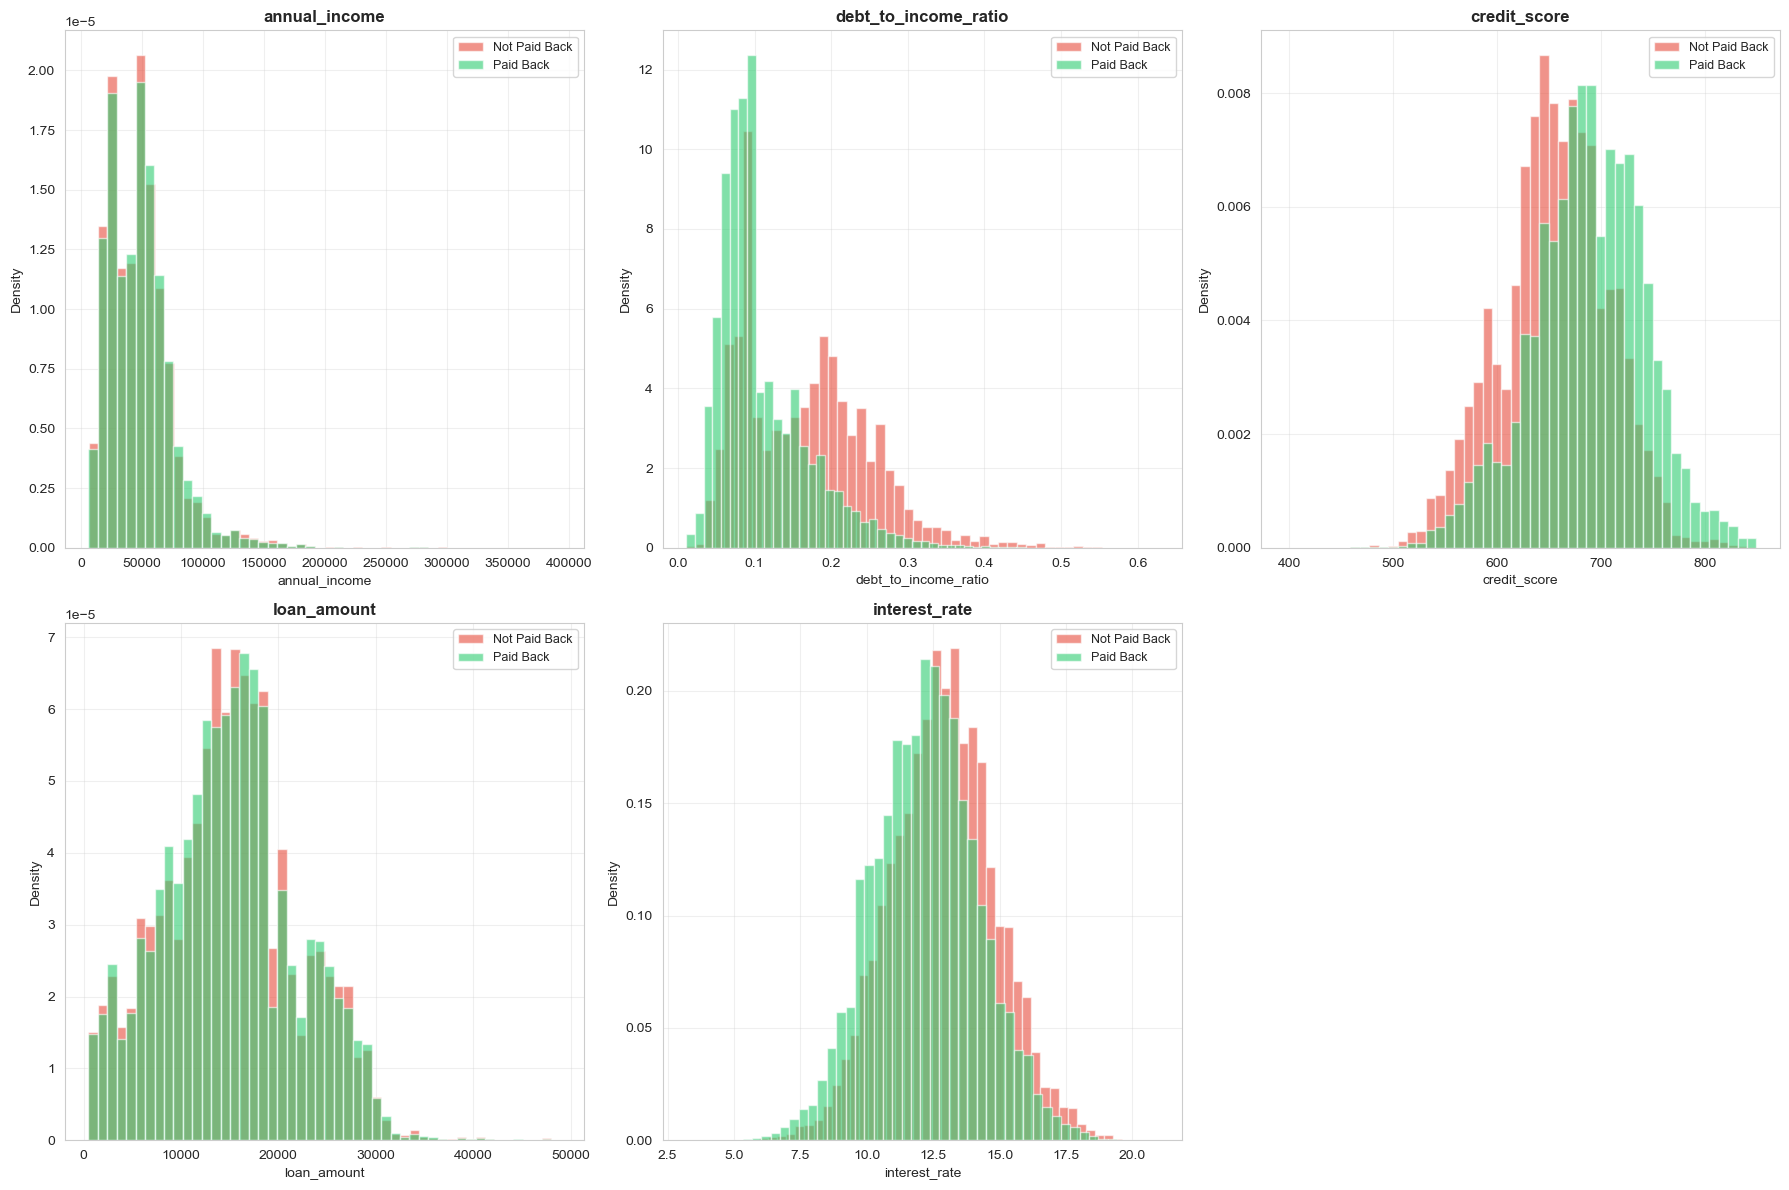

In [8]:
# Distribution of numerical features by target
n_cols = 3
n_rows = (len(numerical_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

for idx, feature in enumerate(numerical_features):
    ax = axes[idx]
    
    # Create histogram for each class
    train_df[train_df['loan_paid_back'] == 0][feature].hist(
        bins=50, alpha=0.6, label='Not Paid Back', color='#e74c3c', ax=ax, density=True
    )
    train_df[train_df['loan_paid_back'] == 1][feature].hist(
        bins=50, alpha=0.6, label='Paid Back', color='#2ecc71', ax=ax, density=True
    )
    
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(len(numerical_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()


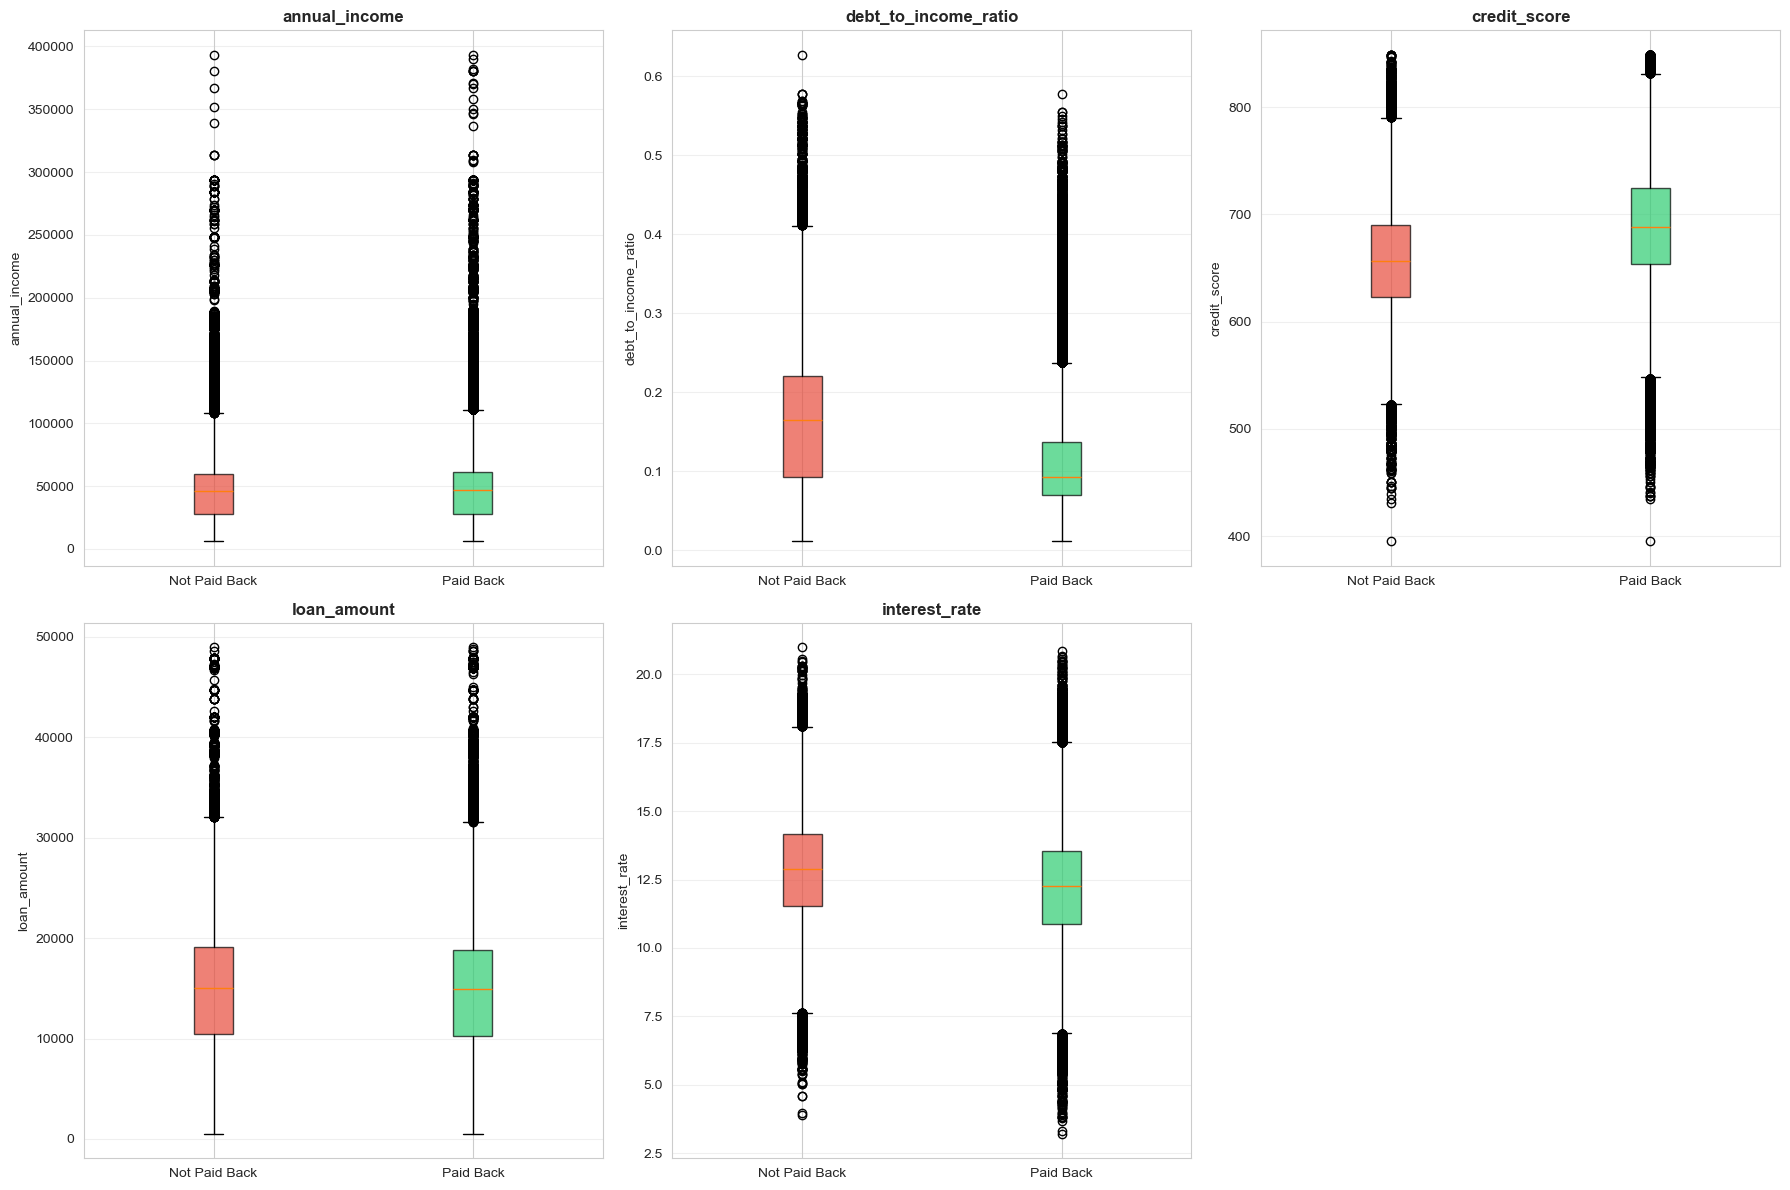

In [9]:
# Box plots for numerical features by target
n_cols = 3
n_rows = (len(numerical_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

for idx, feature in enumerate(numerical_features):
    ax = axes[idx]
    
    # Prepare data for box plot
    data_to_plot = [
        train_df[train_df['loan_paid_back'] == 0][feature],
        train_df[train_df['loan_paid_back'] == 1][feature]
    ]
    
    bp = ax.boxplot(data_to_plot, labels=['Not Paid Back', 'Paid Back'], patch_artist=True)
    
    # Color the boxes
    colors = ['#e74c3c', '#2ecc71']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.set_ylabel(feature, fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

# Hide extra subplots
for idx in range(len(numerical_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()


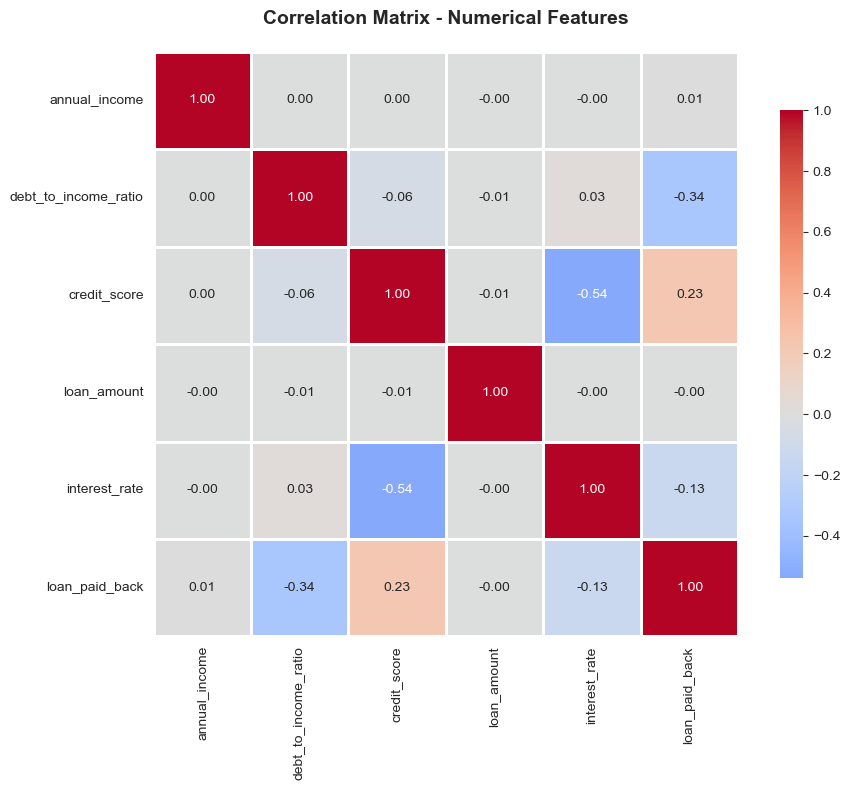

CORRELATION WITH TARGET (loan_paid_back)
credit_score             :  0.2346
annual_income            :  0.0063
loan_amount              : -0.0038
interest_rate            : -0.1312
debt_to_income_ratio     : -0.3357


In [10]:
# Correlation matrix for numerical features
corr_matrix = train_df[numerical_features + ['loan_paid_back']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Numerical Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Correlation with target
print("=" * 60)
print("CORRELATION WITH TARGET (loan_paid_back)")
print("=" * 60)
target_corr = corr_matrix['loan_paid_back'].drop('loan_paid_back').sort_values(ascending=False)
for feature, corr in target_corr.items():
    print(f"{feature:25s}: {corr:7.4f}")


## 6. Categorical Features Analysis


In [11]:
# Check unique values for each categorical feature
print("=" * 60)
print("CATEGORICAL FEATURES - UNIQUE VALUES")
print("=" * 60)
for feature in categorical_features:
    unique_vals = train_df[feature].unique()
    print(f"\n{feature}:")
    print(f"  Unique values: {len(unique_vals)}")
    print(f"  Values: {sorted(unique_vals) if len(unique_vals) < 20 else f'{sorted(unique_vals)[:10]} ... ({len(unique_vals)} total)'}")


CATEGORICAL FEATURES - UNIQUE VALUES

gender:
  Unique values: 3
  Values: ['Female', 'Male', 'Other']

marital_status:
  Unique values: 4
  Values: ['Divorced', 'Married', 'Single', 'Widowed']

education_level:
  Unique values: 5
  Values: ["Bachelor's", 'High School', "Master's", 'Other', 'PhD']

employment_status:
  Unique values: 5
  Values: ['Employed', 'Retired', 'Self-employed', 'Student', 'Unemployed']

loan_purpose:
  Unique values: 8
  Values: ['Business', 'Car', 'Debt consolidation', 'Education', 'Home', 'Medical', 'Other', 'Vacation']

grade_subgrade:
  Unique values: 30
  Values: ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5'] ... (30 total)


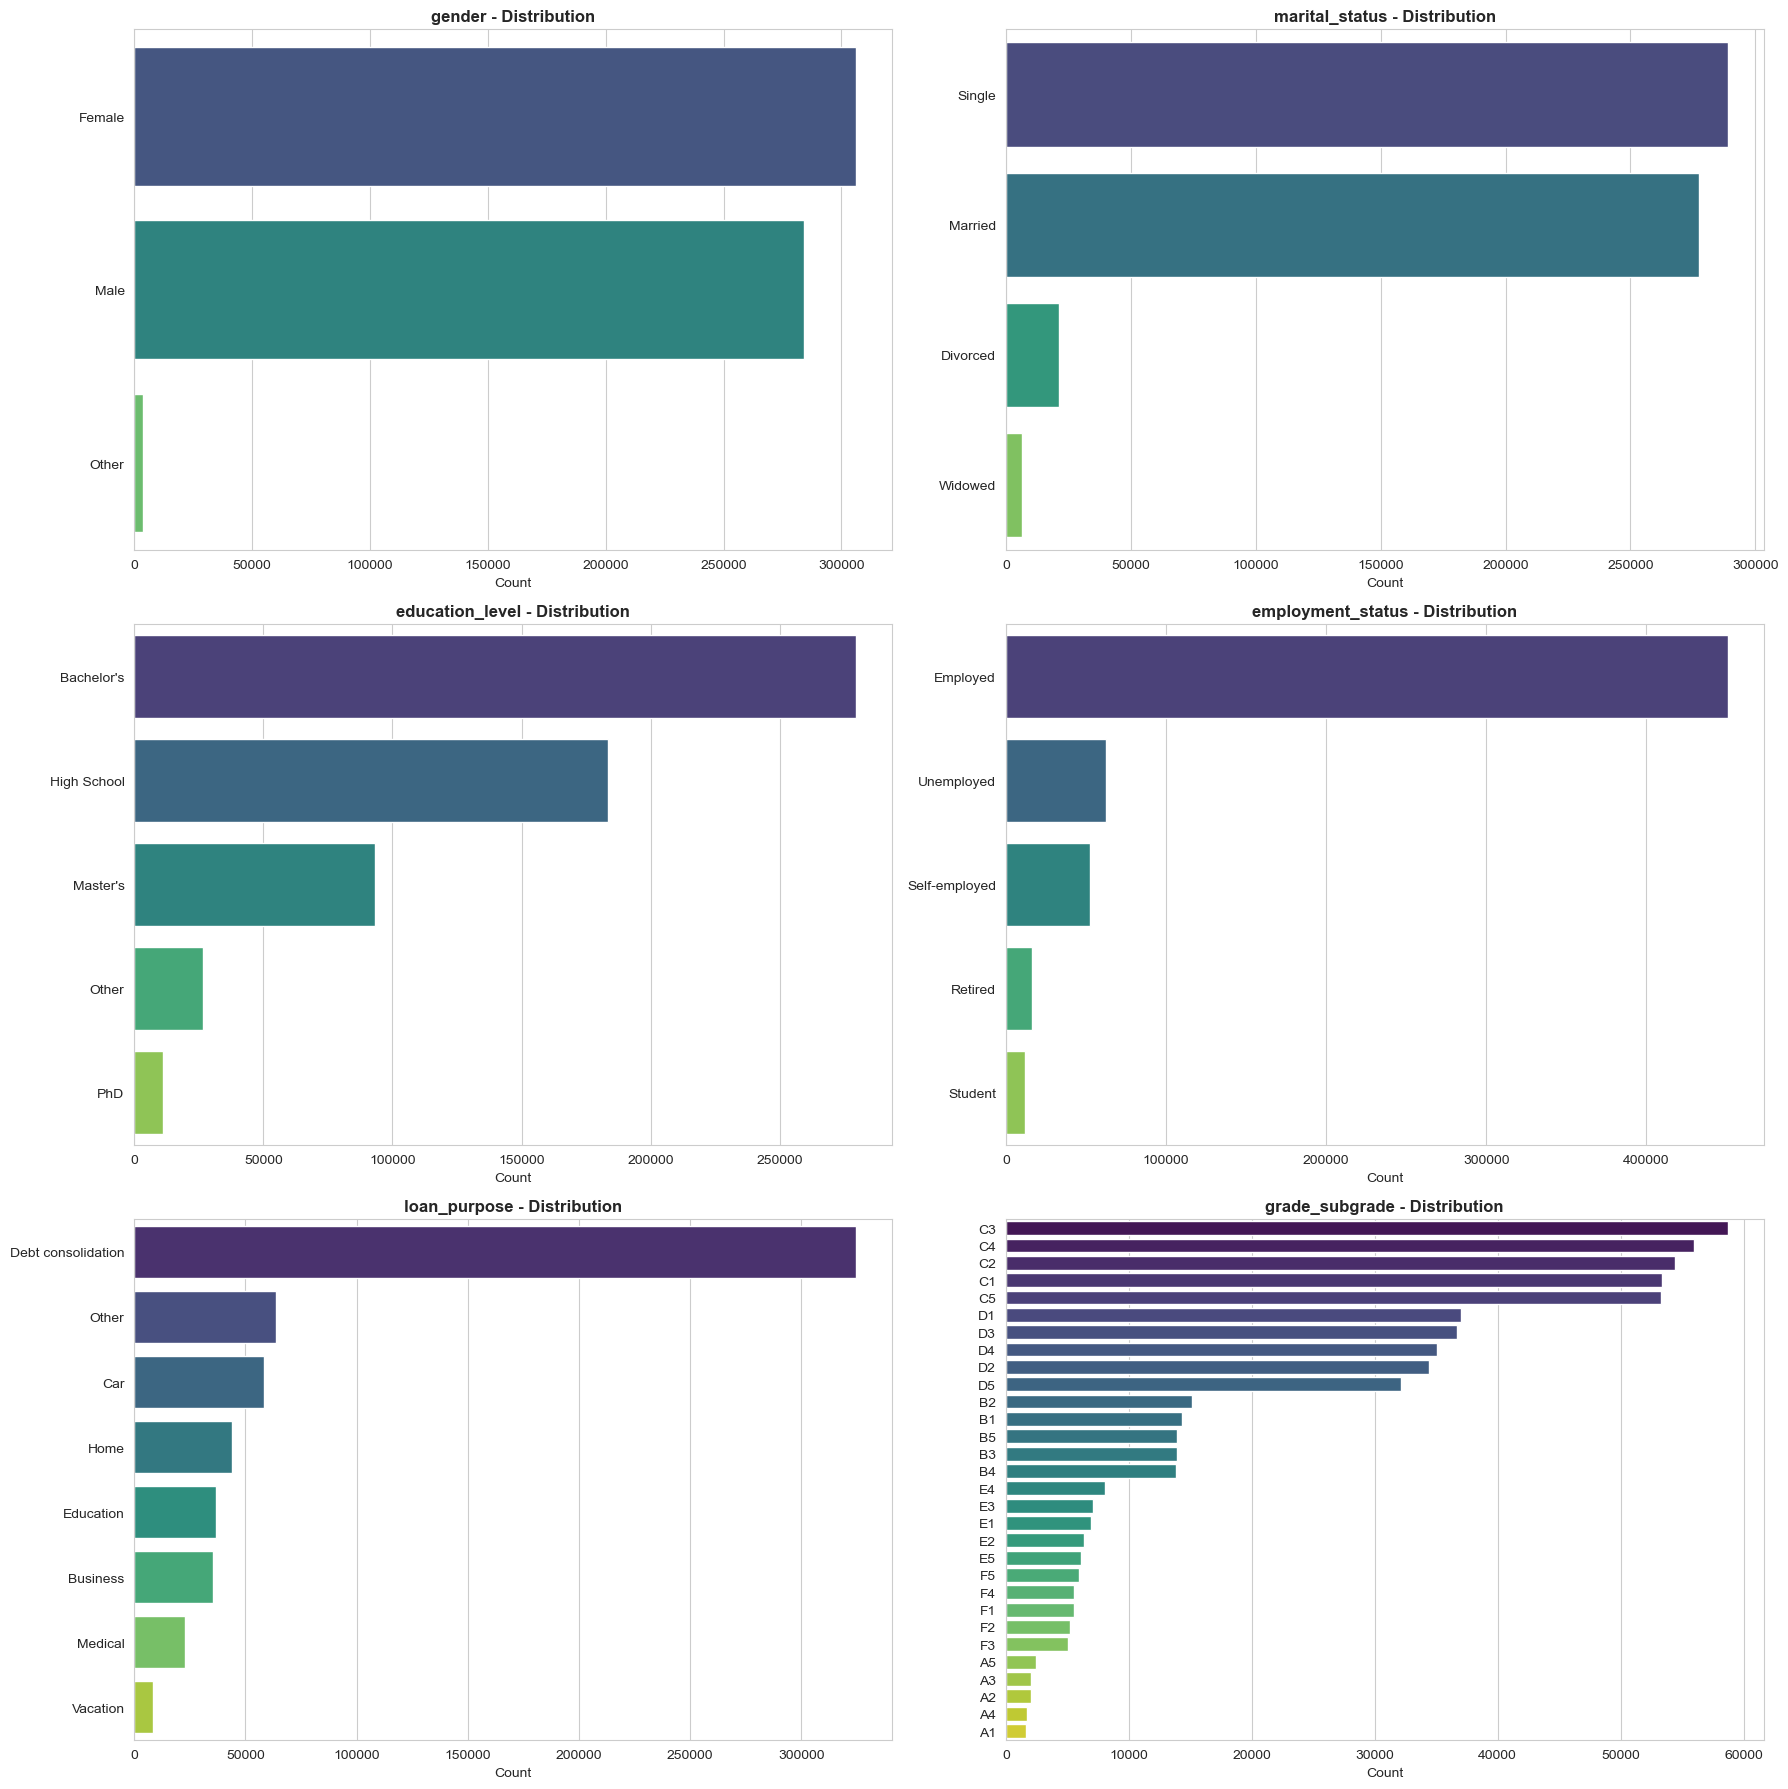

In [12]:
# Distribution of categorical features
n_cols = 2
n_rows = (len(categorical_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

for idx, feature in enumerate(categorical_features):
    ax = axes[idx]
    
    # Count plot
    sns.countplot(data=train_df, y=feature, ax=ax, palette='viridis', order=train_df[feature].value_counts().index)
    ax.set_title(f'{feature} - Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('Count', fontsize=10)
    ax.set_ylabel('')

plt.tight_layout()
plt.show()


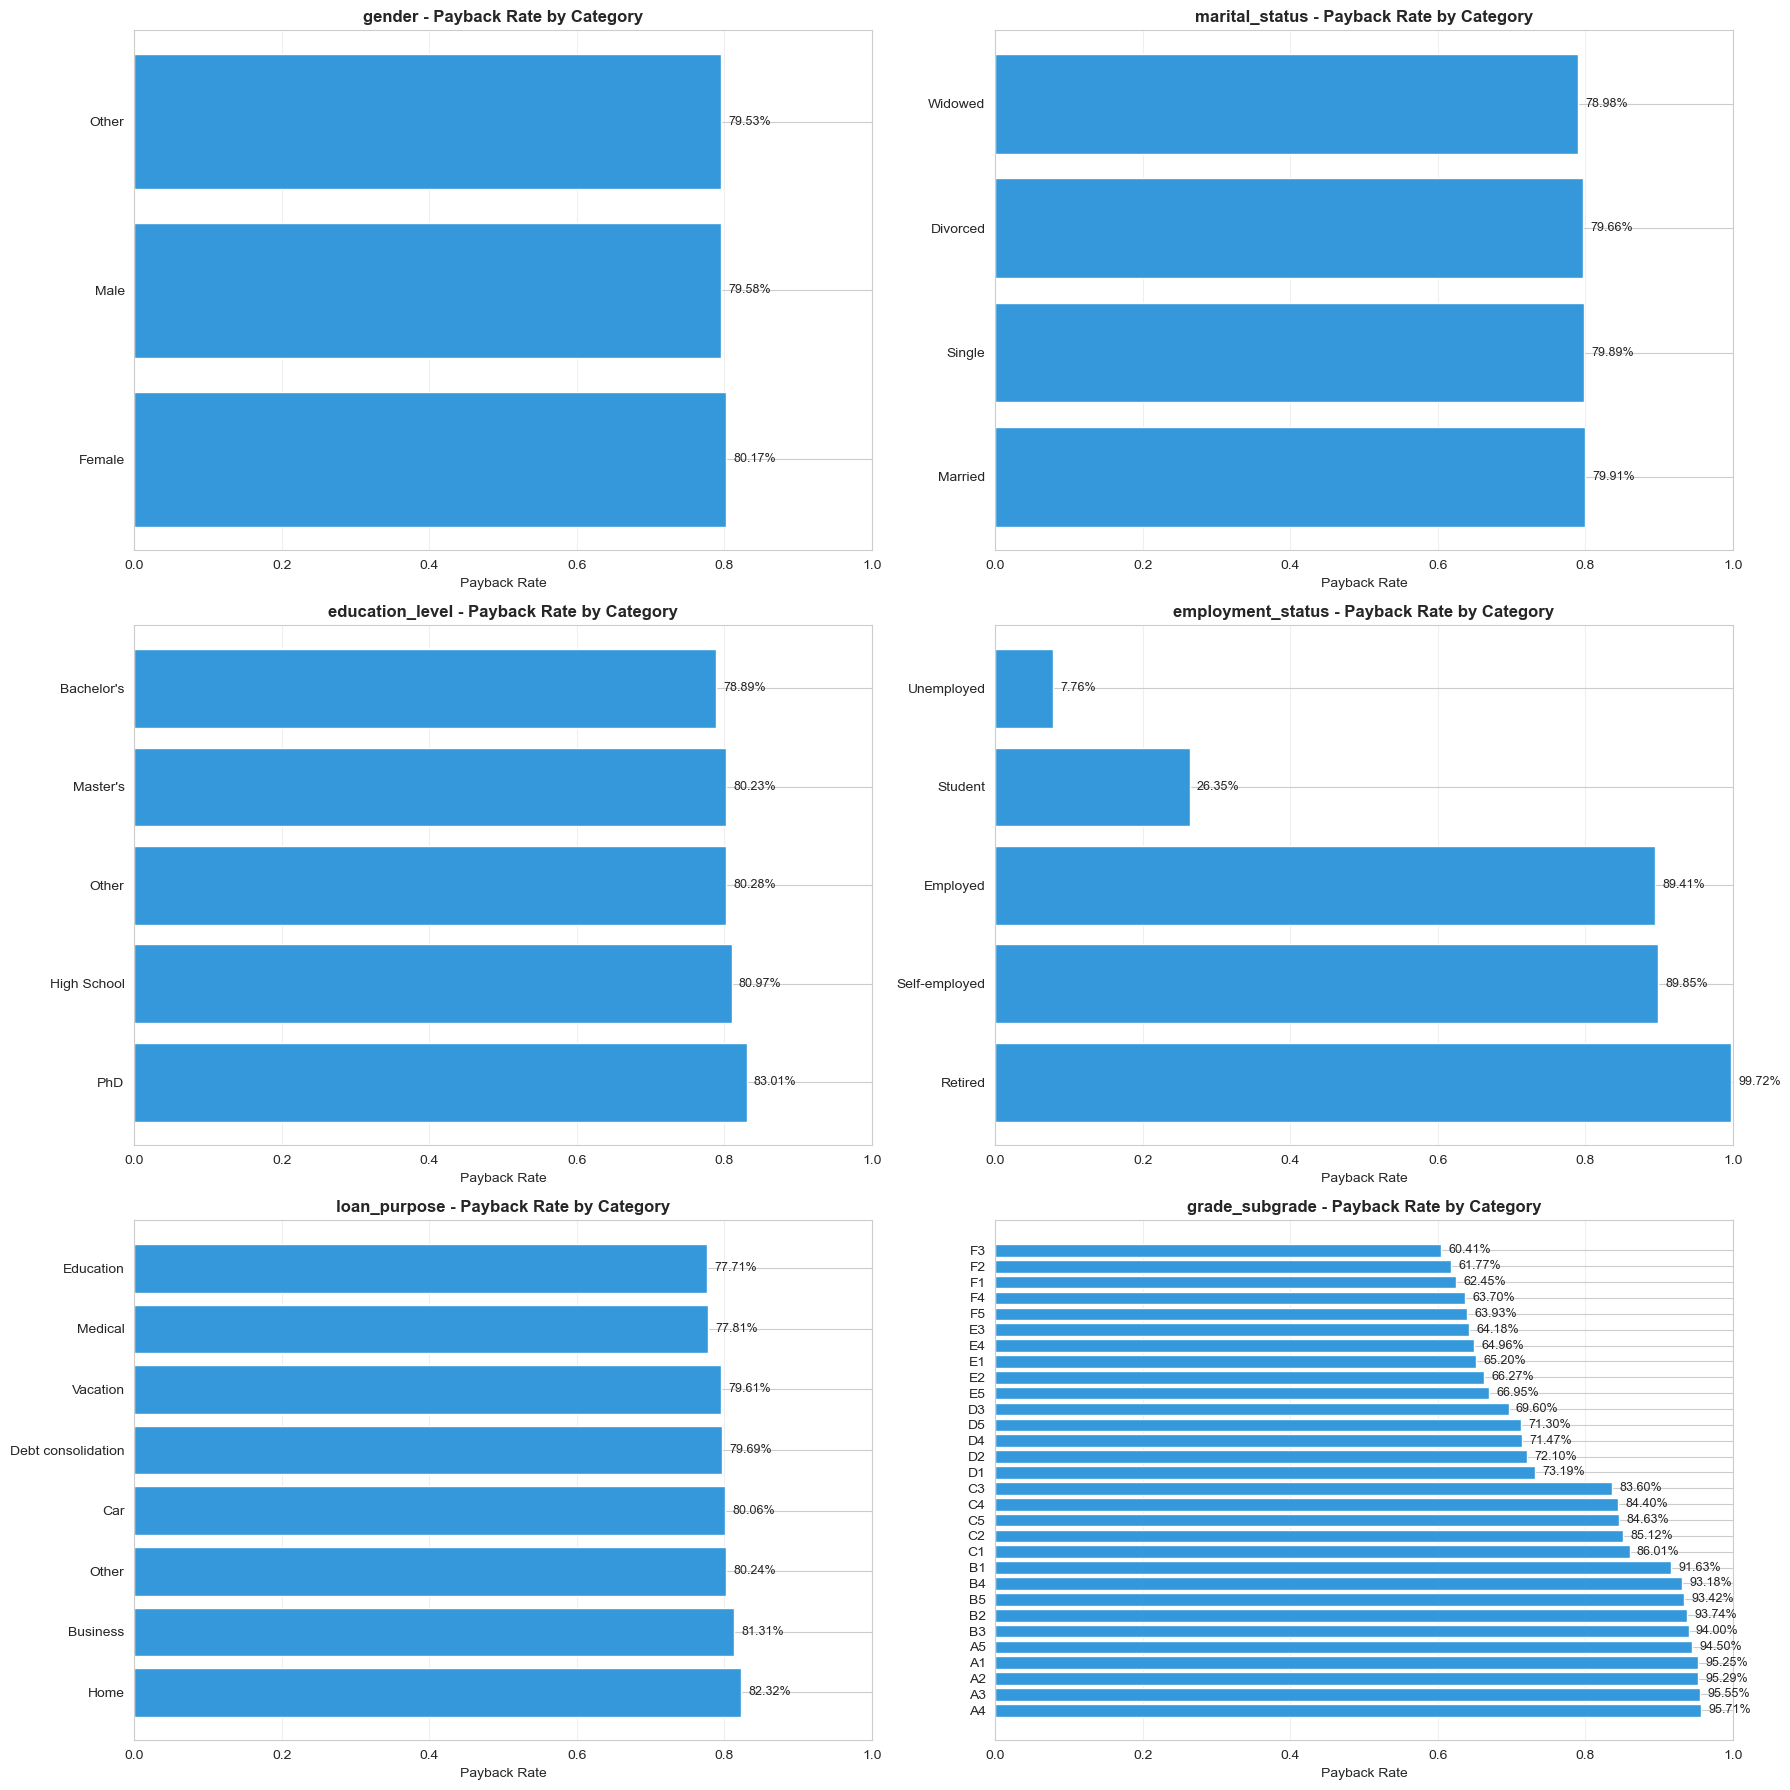

In [13]:
# Categorical features vs target - Payback rate by category
n_cols = 2
n_rows = (len(categorical_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

for idx, feature in enumerate(categorical_features):
    ax = axes[idx]
    
    # Calculate payback rate by category
    payback_rate = train_df.groupby(feature)['loan_paid_back'].mean().sort_values(ascending=False)
    
    # Create bar plot
    bars = ax.barh(range(len(payback_rate)), payback_rate.values, color='#3498db')
    ax.set_yticks(range(len(payback_rate)))
    ax.set_yticklabels(payback_rate.index)
    ax.set_xlabel('Payback Rate', fontsize=10)
    ax.set_title(f'{feature} - Payback Rate by Category', fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add percentage labels
    for i, (bar, rate) in enumerate(zip(bars, payback_rate.values)):
        ax.text(rate + 0.01, i, f'{rate:.2%}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


In [14]:
# Detailed breakdown: count and percentage for each category by target
for feature in categorical_features:
    print("=" * 60)
    print(f"{feature.upper()} - DETAILED BREAKDOWN")
    print("=" * 60)
    
    crosstab = pd.crosstab(train_df[feature], train_df['loan_paid_back'], margins=True)
    crosstab_pct = pd.crosstab(train_df[feature], train_df['loan_paid_back'], normalize='index') * 100
    
    # Combine counts and percentages
    result_df = pd.DataFrame({
        'Not Paid Back (Count)': crosstab[0],
        'Paid Back (Count)': crosstab[1],
        'Not Paid Back (%)': crosstab_pct[0].round(2),
        'Paid Back (%)': crosstab_pct[1].round(2)
    })
    
    display(result_df)
    print()


GENDER - DETAILED BREAKDOWN


,Not Paid Back (Count),Paid Back (Count),Not Paid Back (%),Paid Back (%)
gender,,,,
All,119500,474494,NaN,NaN
Female,60712,245463,19.83,80.17
Male,58025,226066,20.42,79.58
Other,763,2965,20.47,79.53



MARITAL_STATUS - DETAILED BREAKDOWN


,Not Paid Back (Count),Paid Back (Count),Not Paid Back (%),Paid Back (%)
marital_status,,,,
All,119500,474494,NaN,NaN
Divorced,4334,16978,20.34,79.66
Married,55685,221554,20.09,79.91
Single,58094,230749,20.11,79.89
Widowed,1387,5213,21.02,78.98



EDUCATION_LEVEL - DETAILED BREAKDOWN


,Not Paid Back (Count),Paid Back (Count),Not Paid Back (%),Paid Back (%)
education_level,,,,
All,119500,474494,NaN,NaN
Bachelor's,59027,220579,21.11,78.89
High School,34938,148654,19.03,80.97
Master's,18401,74696,19.77,80.23
Other,5261,21416,19.72,80.28
PhD,1873,9149,16.99,83.01



EMPLOYMENT_STATUS - DETAILED BREAKDOWN


,Not Paid Back (Count),Paid Back (Count),Not Paid Back (%),Paid Back (%)
employment_status,,,,
All,119500,474494,NaN,NaN
Employed,47703,402942,10.59,89.41
Retired,46,16407,0.28,99.72
Self-employed,5329,47151,10.15,89.85
Student,8787,3144,73.65,26.35
Unemployed,57635,4850,92.24,7.76



LOAN_PURPOSE - DETAILED BREAKDOWN


,Not Paid Back (Count),Paid Back (Count),Not Paid Back (%),Paid Back (%)
loan_purpose,,,,
All,119500,474494,NaN,NaN
Business,6598,28705,18.69,81.31
Car,11585,46523,19.94,80.06
Debt consolidation,65942,258753,20.31,79.69
Education,8169,28472,22.29,77.71
Home,7799,36319,17.68,82.32
Medical,5061,17745,22.19,77.81
Other,12623,51251,19.76,80.24
Vacation,1723,6726,20.39,79.61



GRADE_SUBGRADE - DETAILED BREAKDOWN


,Not Paid Back (Count),Paid Back (Count),Not Paid Back (%),Paid Back (%)
grade_subgrade,,,,
A1,76,1524,4.75,95.25
A2,95,1923,4.71,95.29
A3,92,1974,4.45,95.55
A4,73,1628,4.29,95.71
A5,136,2335,5.50,94.50
All,119500,474494,NaN,NaN
B1,1200,13144,8.37,91.63
B2,949,14218,6.26,93.74
B3,835,13091,6.00,94.00


## 7. Feature Engineering Insights

Let's create some potential derived features to understand relationships better.


DERIVED FEATURES - CORRELATION WITH TARGET
loan_to_income_ratio          : -0.0056
estimated_monthly_payment     : -0.0468
payment_to_income_ratio       : -0.0298


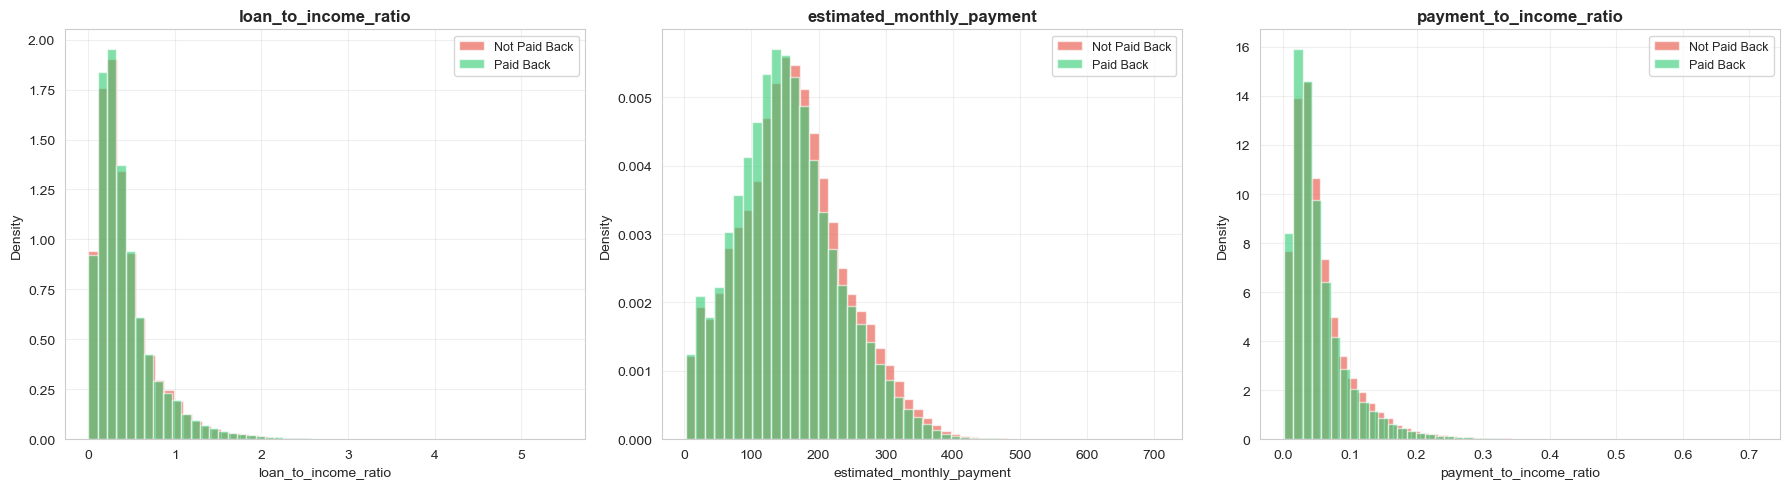

In [15]:
# Create some derived features for analysis
train_analysis = train_df.copy()

# Loan to income ratio
train_analysis['loan_to_income_ratio'] = train_analysis['loan_amount'] / train_analysis['annual_income']

# Monthly payment (rough estimate: P * r * (1+r)^n / ((1+r)^n - 1))
# Using simplified version: Principal * (interest_rate/12) * (1 + interest_rate/12)^36 / ((1 + interest_rate/12)^36 - 1)
# Simplified: monthly_payment ≈ loan_amount * (interest_rate/100/12)
train_analysis['estimated_monthly_payment'] = train_analysis['loan_amount'] * (train_analysis['interest_rate'] / 100 / 12)

# Payment to income ratio
train_analysis['payment_to_income_ratio'] = (train_analysis['estimated_monthly_payment'] * 12) / train_analysis['annual_income']

# Extract grade and subgrade from grade_subgrade
train_analysis['grade'] = train_analysis['grade_subgrade'].str[0]
train_analysis['subgrade_num'] = train_analysis['grade_subgrade'].str[1:].astype(int)

print("=" * 60)
print("DERIVED FEATURES - CORRELATION WITH TARGET")
print("=" * 60)

derived_features = ['loan_to_income_ratio', 'estimated_monthly_payment', 'payment_to_income_ratio']
for feature in derived_features:
    corr = train_analysis[feature].corr(train_analysis['loan_paid_back'])
    print(f"{feature:30s}: {corr:7.4f}")
    
# Visualize derived features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(derived_features):
    ax = axes[idx]
    
    train_analysis[train_analysis['loan_paid_back'] == 0][feature].hist(
        bins=50, alpha=0.6, label='Not Paid Back', color='#e74c3c', ax=ax, density=True
    )
    train_analysis[train_analysis['loan_paid_back'] == 1][feature].hist(
        bins=50, alpha=0.6, label='Paid Back', color='#2ecc71', ax=ax, density=True
    )
    
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


GRADE AND SUBGRADE ANALYSIS

Payback Rate by Grade (sorted by rate):


,Payback Rate,Count
grade,,
A,0.952110,9856
B,0.931959,71251
C,0.847260,275775
D,0.715334,175353
E,0.654420,34458
F,0.625179,27301


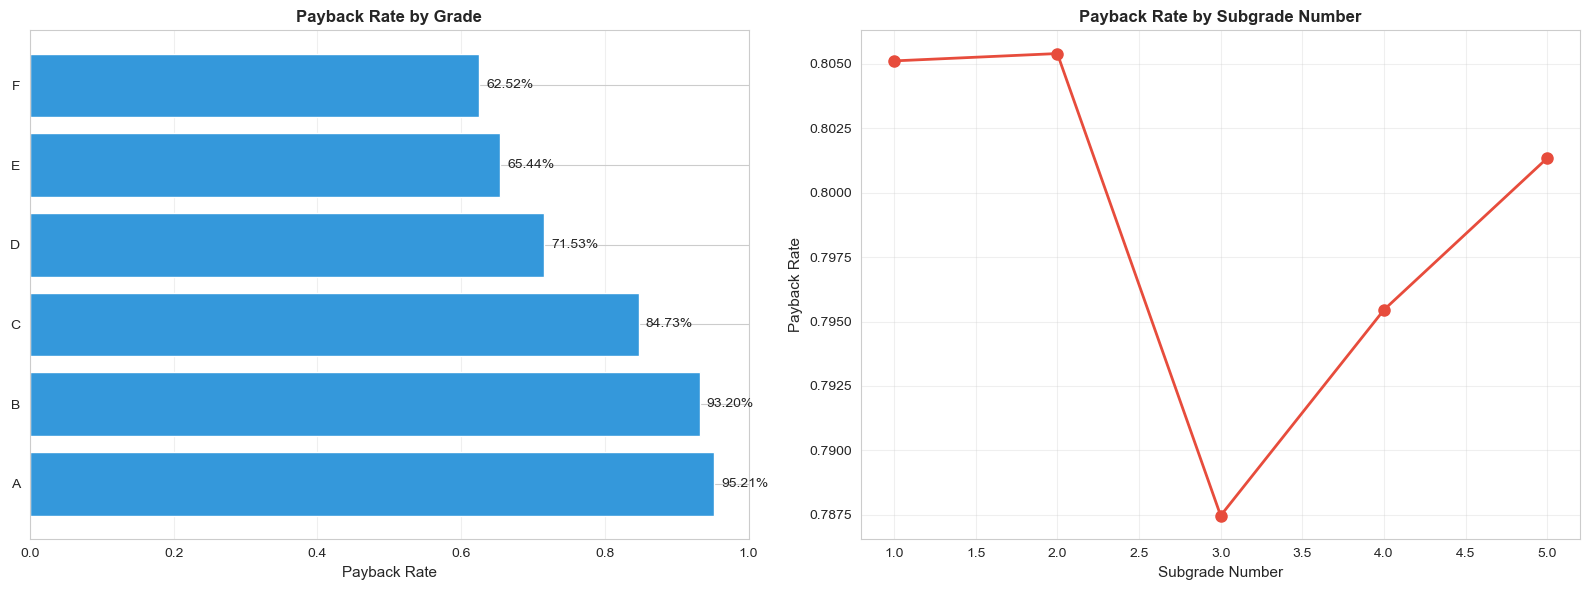

In [16]:
# Analyze grade and subgrade
print("=" * 60)
print("GRADE AND SUBGRADE ANALYSIS")
print("=" * 60)

# Grade analysis
grade_payback = train_analysis.groupby('grade')['loan_paid_back'].agg(['mean', 'count']).sort_values('mean', ascending=False)
grade_payback.columns = ['Payback Rate', 'Count']
print("\nPayback Rate by Grade (sorted by rate):")
display(grade_payback)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Grade payback rate
axes[0].barh(range(len(grade_payback)), grade_payback['Payback Rate'].values, color='#3498db')
axes[0].set_yticks(range(len(grade_payback)))
axes[0].set_yticklabels(grade_payback.index)
axes[0].set_xlabel('Payback Rate', fontsize=11)
axes[0].set_title('Payback Rate by Grade', fontsize=12, fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].grid(True, alpha=0.3, axis='x')

for i, rate in enumerate(grade_payback['Payback Rate'].values):
    axes[0].text(rate + 0.01, i, f'{rate:.2%}', va='center', fontsize=10)

# Subgrade number vs payback rate
subgrade_payback = train_analysis.groupby('subgrade_num')['loan_paid_back'].mean().sort_index()
axes[1].plot(subgrade_payback.index, subgrade_payback.values, marker='o', linewidth=2, markersize=8, color='#e74c3c')
axes[1].set_xlabel('Subgrade Number', fontsize=11)
axes[1].set_ylabel('Payback Rate', fontsize=11)
axes[1].set_title('Payback Rate by Subgrade Number', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Train vs Test Distribution Comparison

Let's check if the test set has a similar distribution to the training set.


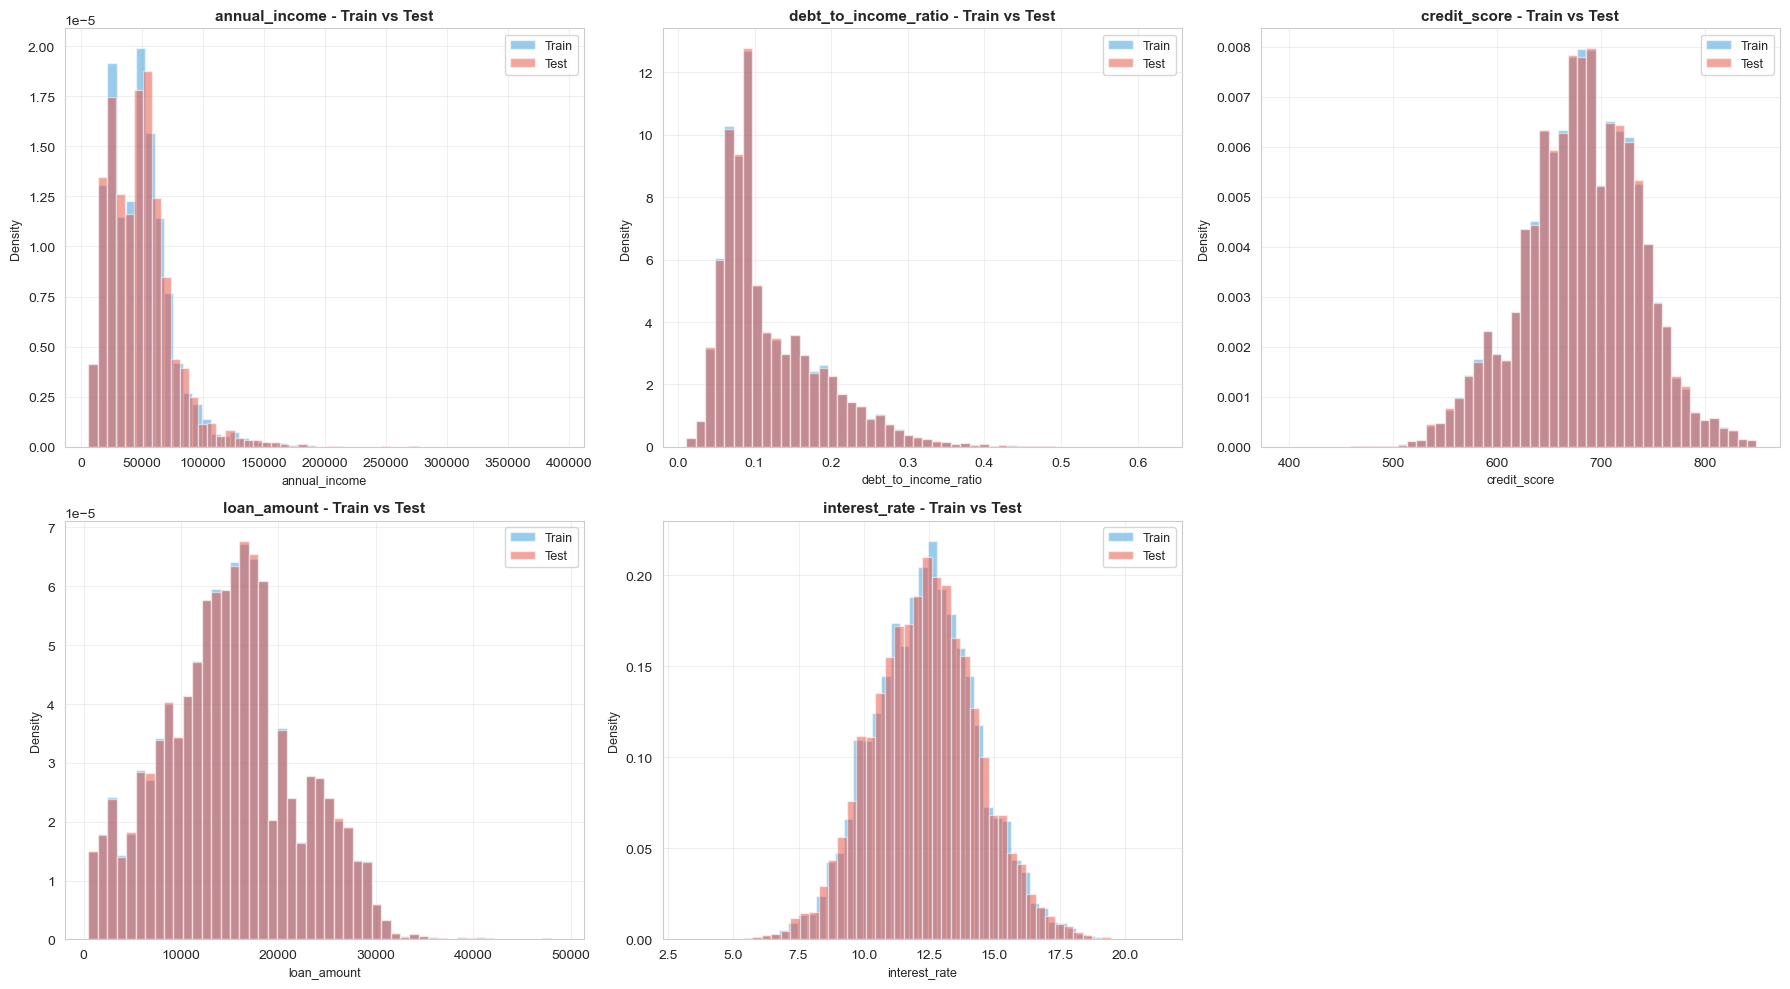

In [17]:
# Compare distributions between train and test for numerical features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(numerical_features[:6]):  # Show first 6 numerical features
    ax = axes[idx]
    
    train_df[feature].hist(bins=50, alpha=0.5, label='Train', color='#3498db', ax=ax, density=True)
    test_df[feature].hist(bins=50, alpha=0.5, label='Test', color='#e74c3c', ax=ax, density=True)
    
    ax.set_title(f'{feature} - Train vs Test', fontsize=11, fontweight='bold')
    ax.set_xlabel(feature, fontsize=9)
    ax.set_ylabel('Density', fontsize=9)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(len(numerical_features[:6]), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()


In [18]:
# Compare categorical distributions
for feature in categorical_features[:3]:  # Show first 3 categorical features
    print("=" * 60)
    print(f"{feature.upper()} - TRAIN VS TEST")
    print("=" * 60)
    
    train_counts = train_df[feature].value_counts(normalize=True).sort_index() * 100
    test_counts = test_df[feature].value_counts(normalize=True).sort_index() * 100
    
    comparison = pd.DataFrame({
        'Train %': train_counts,
        'Test %': test_counts
    }).fillna(0)
    
    comparison['Difference'] = comparison['Train %'] - comparison['Test %']
    display(comparison.sort_values('Difference', key=abs, ascending=False))
    print()


GENDER - TRAIN VS TEST


,Train %,Test %,Difference
gender,,,
Male,47.827251,47.706909,0.120342
Female,51.545133,51.648080,-0.102946
Other,0.627616,0.645012,-0.017396



MARITAL_STATUS - TRAIN VS TEST


,Train %,Test %,Difference
marital_status,,,
Married,46.673704,46.745676,-0.071972
Single,48.627259,48.586434,0.040825
Widowed,1.111122,1.084578,0.026544
Divorced,3.587915,3.583311,0.004604



EDUCATION_LEVEL - TRAIN VS TEST


,Train %,Test %,Difference
education_level,,,
Other,4.491123,4.448696,0.042427
Bachelor's,47.072193,47.108642,-0.036450
PhD,1.855574,1.888290,-0.032715
Master's,15.673054,15.644481,0.028572
High School,30.908056,30.909891,-0.001835


## 9. Key Insights and Summary


In [19]:
print("=" * 60)
print("KEY INSIGHTS SUMMARY")
print("=" * 60)

print("\n1. DATASET SIZE:")
print(f"   - Training samples: {len(train_df):,}")
print(f"   - Test samples: {len(test_df):,}")
print(f"   - Train/Test ratio: {len(train_df)/len(test_df):.2f}")

print("\n2. TARGET DISTRIBUTION:")
target_dist = train_df['loan_paid_back'].value_counts(normalize=True)
print(f"   - Paid Back: {target_dist[1]:.2%}")
print(f"   - Not Paid Back: {target_dist[0]:.2%}")
print(f"   - Dataset is {'balanced' if 0.4 < target_dist[0] < 0.6 else 'imbalanced'}")

print("\n3. FEATURES:")
print(f"   - Numerical features: {len(numerical_features)}")
print(f"   - Categorical features: {len(categorical_features)}")

print("\n4. STRONGEST CORRELATIONS WITH TARGET (Numerical):")
top_corr = train_df[numerical_features + ['loan_paid_back']].corr()['loan_paid_back'].drop('loan_paid_back').abs().sort_values(ascending=False)
for feat, corr in top_corr.head(5).items():
    actual_corr = train_df[feat].corr(train_df['loan_paid_back'])
    print(f"   - {feat}: {actual_corr:.4f}")

print("\n5. CATEGORICAL FEATURES WITH HIGHEST VARIANCE IN PAYBACK RATE:")
for feat in categorical_features:
    payback_rates = train_df.groupby(feat)['loan_paid_back'].mean()
    variance = payback_rates.max() - payback_rates.min()
    if variance > 0.1:  # Only show features with >10% difference between min and max
        print(f"   - {feat}: {variance:.2%} difference (range: {payback_rates.min():.2%} - {payback_rates.max():.2%})")

print("\n6. DATA QUALITY:")
print(f"   - Missing values: {'None ✓' if train_df.isnull().sum().sum() == 0 else f'{train_df.isnull().sum().sum()} missing values found'}")
print(f"   - Duplicate IDs in train: {train_df['id'].duplicated().sum()}")
print(f"   - Duplicate IDs in test: {test_df['id'].duplicated().sum()}")

print("\n" + "=" * 60)


KEY INSIGHTS SUMMARY

1. DATASET SIZE:
   - Training samples: 593,994
   - Test samples: 254,569
   - Train/Test ratio: 2.33

2. TARGET DISTRIBUTION:
   - Paid Back: 79.88%
   - Not Paid Back: 20.12%
   - Dataset is imbalanced

3. FEATURES:
   - Numerical features: 5
   - Categorical features: 6

4. STRONGEST CORRELATIONS WITH TARGET (Numerical):
   - debt_to_income_ratio: -0.3357
   - credit_score: 0.2346
   - interest_rate: -0.1312
   - annual_income: 0.0063
   - loan_amount: -0.0038

5. CATEGORICAL FEATURES WITH HIGHEST VARIANCE IN PAYBACK RATE:
   - employment_status: 91.96% difference (range: 7.76% - 99.72%)
   - grade_subgrade: 35.30% difference (range: 60.41% - 95.71%)

6. DATA QUALITY:
   - Missing values: None ✓
   - Duplicate IDs in train: 0
   - Duplicate IDs in test: 0

